In [1]:
import h5py
import numpy as np
import scipy.io
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline 

# 1. Data Cleaning and Preprocessing (for dataset A)

In [265]:
dataA = scipy.io.loadmat('./DataA.mat')
dataB = scipy.io.loadmat('./DataB.mat')
dataC = scipy.io.loadmat('./DataC.mat')

print('Succesfully loaded data!')
print("Data A shape:", dataA['fea'].shape)
print("Data B shape:", dataB['fea'].shape)
print("Data C shape:", dataC['fea'].shape)

Succesfully loaded data!
Data A shape: (19000, 81)
Data B shape: (2066, 784)
Data C shape: (2100, 21)


## Replace missing values (NaN) by mean value

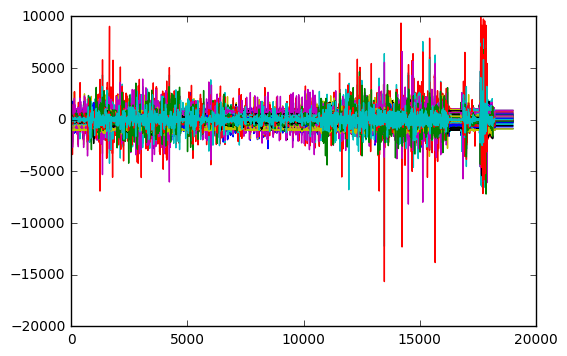

In [267]:
a_features = dataA['fea']

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
a_features_clean = imp.fit_transform(a_features)

plt.plot(a_features_clean);

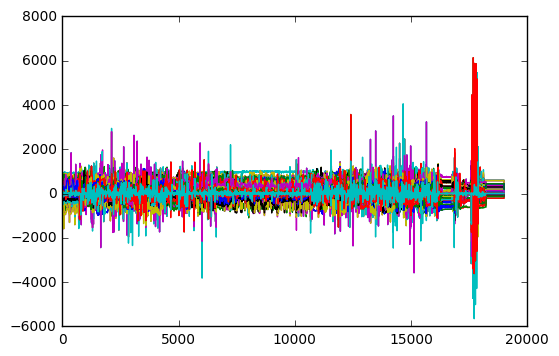

In [324]:
from scipy import signal

filtered = signal.medfilt(a_features_clean)
plt.plot(filtered);

## Normalize data

In [268]:
min_max_scaler = MinMaxScaler()

X_train_minmax = min_max_scaler.fit_transform(a_features_clean)
X_train_standardized = scale(X_train_minmax)

## Plot histograms of feature 9 and 24

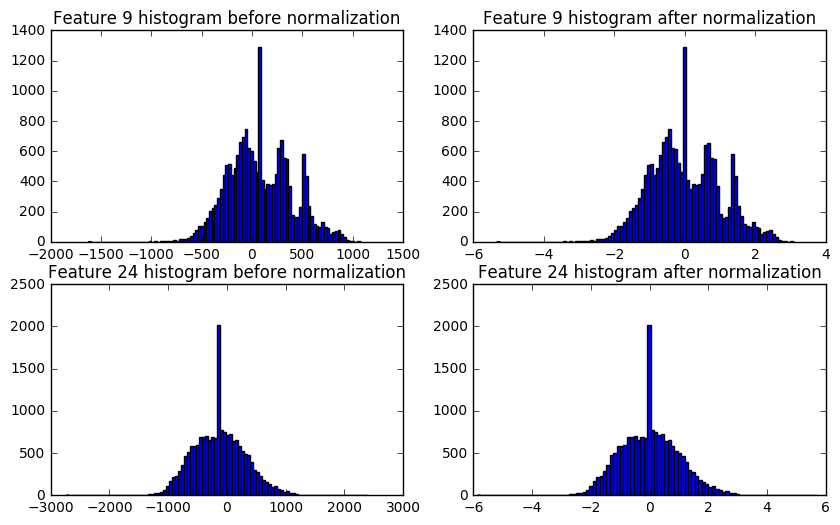

In [317]:
plt.figure(1, figsize=(10, 6))
plt.subplot(222).set_title("Feature 9 histogram after normalization")
plt.hist(X_train_standardized[:, 8], bins=100);
plt.subplot(224).set_title("Feature 24 histogram after normalization")
plt.hist(X_train_standardized[:, 23], bins=100);

plt.subplot(221).set_title("Feature 9 histogram before normalization")
plt.hist(a_features_clean[:, 8], bins=100);
plt.subplot(223).set_title("Feature 24 histogram before normalization")
plt.hist(a_features_clean[:, 23], bins=100);

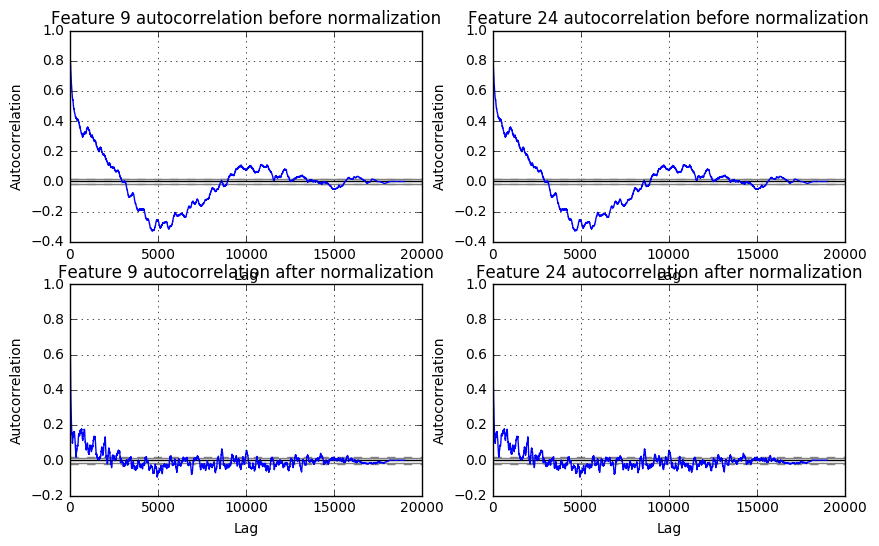

In [286]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0][0].set_title("Feature 9 autocorrelation before normalization")
axes[0][1].set_title("Feature 24 autocorrelation before normalization")
axes[1][0].set_title("Feature 9 autocorrelation after normalization")
axes[1][1].set_title("Feature 24 autocorrelation after normalization")

pd.tools.plotting.autocorrelation_plot(X_train_standardized[:, 8], ax=axes[0][1])
pd.tools.plotting.autocorrelation_plot(X_train_standardized[:, 23], ax=axes[1][1])
pd.tools.plotting.autocorrelation_plot(a_features_clean[:, 8], ax=axes[0][0])
pd.tools.plotting.autocorrelation_plot(a_features_clean[:, 23], ax=axes[1][0])

# 2. Feature Extraction (for dataset B)

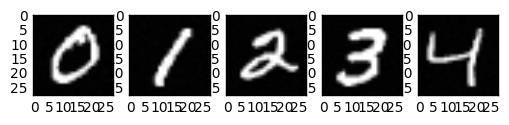

In [345]:
X_train = dataB['fea']
y_train = dataB['gnd'].ravel()

fig, ax = plt.subplots(1, 5)

for i in range(5):  
    img = X_train[[y_train == i]][0].reshape(28, 28)
    ax[i].imshow(img, cmap='gray')

## Use PCA for dimensonality reduction

In [334]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(X_train)
print(pca.explained_variance_.sum())

3376606.89217


## Plot 2D representation of points

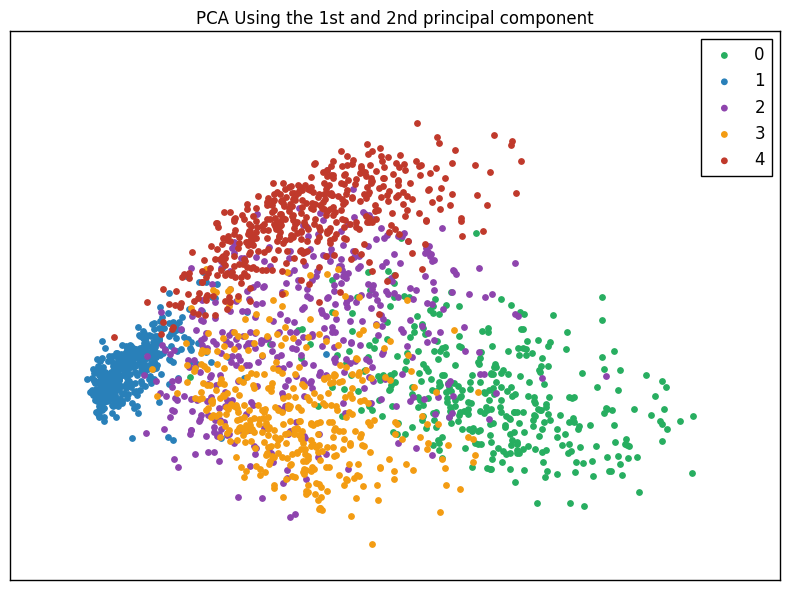

In [273]:
fig, plot = plt.subplots(figsize=(8, 6))
#fig.set_size_inches(25, 25)
plt.prism()

X_transformed = pca.fit_transform(X_train)
colors = [
    ('#27ae60', 'o'),
    ('#2980b9', 'o'),
    ('#8e44ad', 'o'),
    ('#f39c12', 'o'),
    ('#c0392b', 'o'),
]
labels = np.unique(y_train)
for num in range(len(labels)):
    plt.scatter([X_transformed[:,0][i] for i in range(len(y_train)) if y_train[i] == num],
    [X_transformed[:,1][i] for i in range(len(y_train)) if y_train[i] == num], 15,
    label=str(num), color = colors[num][0], marker=colors[num][1])#, edgecolors='black')
    
plt.legend(scatterpoints=1)
plt.title("PCA Using the 1st and 2nd principal component")
plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()

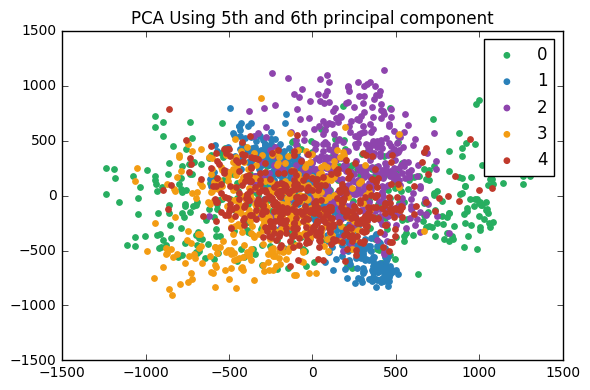

In [274]:
for num in range(len(labels)):
    plt.scatter([X_transformed[:,4][i] for i in range(len(y_train)) if y_train[i] == num],
    [X_transformed[:,5][i] for i in range(len(y_train)) if y_train[i] == num], 15,
    label=str(num), color = colors[num][0], marker=colors[num][1])#, edgecolors='black')
    
plt.legend(scatterpoints=1)
plt.title("PCA Using 5th and 6th principal component")

plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()

In [336]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_train = y_train.ravel()
error_rates = []
rm = []
components = [2, 4, 10, 30, 60, 200, 500, 784]

for component in components:
    X_train = X_transformed[:, :component]
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_train)
    error_rate = (y_pred != y_train).mean()
    error_rates.append(error_rate)
    rm.append(pca.explained_variance_ratio_[:component].sum())
    print("Error rate: %.6f (%d components)" % (error_rate, component))

Error rate: 0.239109 (2 components)
Error rate: 0.157309 (4 components)
Error rate: 0.074056 (10 components)
Error rate: 0.060987 (30 components)
Error rate: 0.046951 (60 components)
Error rate: 0.060503 (200 components)
Error rate: 0.190707 (500 components)
Error rate: 0.232333 (784 components)


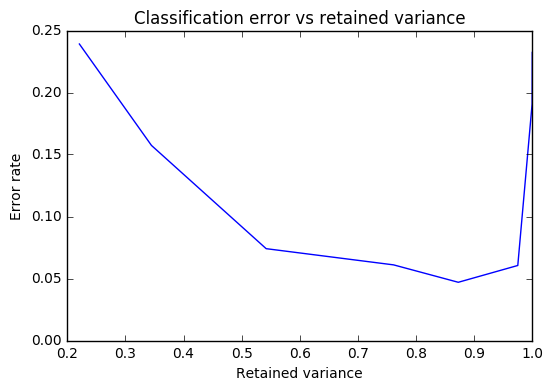

In [339]:
plt.plot(rm, error_rates)
plt.xlabel("Retained variance")
plt.ylabel("Error rate")

plt.title("Classification error vs retained variance")

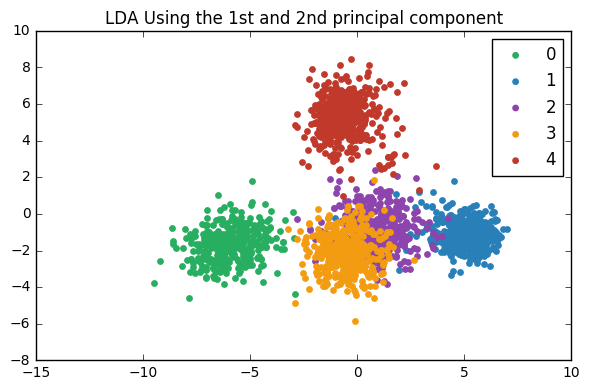

In [183]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_transformed = lda.fit_transform(X_train, y_train)

for num in range(len(labels)):
    plt.scatter([X_transformed[:,0][i] for i in range(len(y_train)) if y_train[i] == num],
    [X_transformed[:,1][i] for i in range(len(y_train)) if y_train[i] == num], 15,
    label=str(num), color = colors[num][0], marker=colors[num][1])#, edgecolors='black')
    
plt.legend(scatterpoints=1)
plt.title("LDA Using the 1st and 2nd principal component")
plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()

# 3. Nonlinear Dimensionality Reduction (for dataset B)

## Applying LLE to image of digit 3

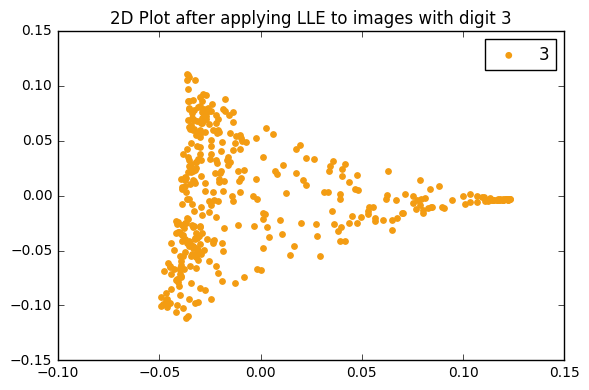

In [184]:
from sklearn.manifold import LocallyLinearEmbedding

X_train = X_train[y_train == 3]
y_train = y_train[y_train == 3]

lle = LocallyLinearEmbedding(n_components=4, n_neighbors=5)

X_transformed = lle.fit_transform(X_train)

num = 3
plt.scatter([X_transformed[:,0][i] for i in range(len(y_train)) if y_train[i] == num],
[X_transformed[:,1][i] for i in range(len(y_train)) if y_train[i] == num], 15,
label=str(num), color = colors[num][0], marker=colors[num][1])#, edgecolors='black')
    
plt.legend(scatterpoints=1)
plt.title("2D Plot after applying LLE to images with digit 3")
plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()

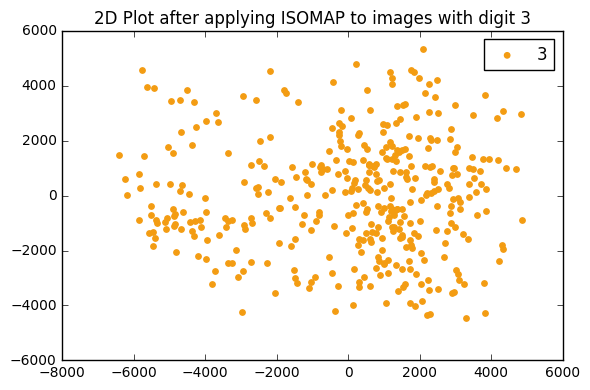

In [185]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=4, n_neighbors=5)
X_transformed = isomap.fit_transform(X_train)

num = 3
plt.scatter([X_transformed[:,0][i] for i in range(len(y_train)) if y_train[i] == num],
[X_transformed[:,1][i] for i in range(len(y_train)) if y_train[i] == num], 15,
label=str(num), color = colors[num][0], marker=colors[num][1])#, edgecolors='black')
    
plt.legend(scatterpoints=1)
plt.title("2D Plot after applying ISOMAP to images with digit 3")
plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()

## Classify digits with Naive Bayes using LLE and ISOMAP

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

features = dataB['fea']
labels = dataB['gnd'].ravel()

lle_train_err = []
lle_test_err = []
isomap_train_err = []
isomap_test_err = []

clf = GaussianNB()
isomap = Isomap(n_components=4, n_neighbors=5, n_jobs=-1)
lle = LocallyLinearEmbedding(n_components=4, n_neighbors=5, n_jobs=-1)

n_iterations = 10

for i in range(n_iterations):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)
    
    X_transformed = lle.fit_transform(X_train)
    X_test_transformed = lle.transform(X_test)
    
    clf.fit(X_transformed, y_train)
    y_pred = clf.predict(X_transformed)
    train_error_rate = (y_pred != y_train).mean()
    lle_train_err.append(train_error_rate)
    
    y_pred = clf.predict(X_test_transformed)
    test_error_rate = (y_pred != y_test).mean()
    lle_test_err.append(test_error_rate)
    
    X_transformed = isomap.fit_transform(X_train)
    X_test_transformed = isomap.transform(X_test)
    
    clf.fit(X_transformed, y_train)
    y_pred = clf.predict(X_transformed)
    train_error_rate = (y_pred != y_train).mean()
    isomap_train_err.append(train_error_rate)
    
    y_pred = clf.predict(X_test_transformed)
    test_error_rate = (y_pred != y_test).mean()
    isomap_test_err.append(test_error_rate)    

print("LLE training error rate:", np.mean(lle_train_err), "Test error rate:", np.mean(lle_test_err))
print("ISOMAP training error rate:", np.mean(isomap_train_err), "Test error rate:", np.mean(isomap_test_err))

LLE training error rate: 0.0910096818811 Test error rate: 0.0887096774194
ISOMAP training error rate: 0.117634854772 Test error rate: 0.114516129032


# 4. Features Selection (for dataset C)

In [277]:
dataC = scipy.io.loadmat('./DataC.mat')
features = dataC['fea']
labels = dataC['gnd'].ravel()

print(features.shape, labels.shape)

min_max_scaler = MinMaxScaler()

features_normalized = min_max_scaler.fit_transform(features) 

(2100, 21) (2100,)


## Use Sequential Forward Selection to select 8 features

In [278]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()

sfs = SFS(clf, 
        k_features=8, 
        forward=True, 
        floating=False, 
        scoring='accuracy',
        cv=0)

sfs.fit(features_normalized, labels)

sfs.subsets_

Features: 8/8

{1: {'avg_score': 0.82714285714285718,
  'cv_scores': array([ 0.82714286]),
  'feature_idx': (9,)},
 2: {'avg_score': 0.89523809523809528,
  'cv_scores': array([ 0.8952381]),
  'feature_idx': (9, 17)},
 3: {'avg_score': 0.93380952380952376,
  'cv_scores': array([ 0.93380952]),
  'feature_idx': (9, 17, 7)},
 4: {'avg_score': 0.94285714285714284,
  'cv_scores': array([ 0.94285714]),
  'feature_idx': (9, 3, 17, 7)},
 5: {'avg_score': 0.9514285714285714,
  'cv_scores': array([ 0.95142857]),
  'feature_idx': (9, 3, 1, 17, 7)},
 6: {'avg_score': 0.95238095238095233,
  'cv_scores': array([ 0.95238095]),
  'feature_idx': (1, 17, 3, 7, 9, 10)},
 7: {'avg_score': 0.95333333333333337,
  'cv_scores': array([ 0.95333333]),
  'feature_idx': (1, 17, 3, 7, 8, 9, 10)},
 8: {'avg_score': 0.95333333333333337,
  'cv_scores': array([ 0.95333333]),
  'feature_idx': (1, 17, 3, 5, 7, 8, 9, 10)}}

In [279]:
clf = GaussianNB()

sfs = SFS(clf, 
        k_features=8, 
        forward=True, 
        floating=False, 
        scoring='accuracy',
        cv=0)

sfs.fit(features_normalized, labels)

sfs.subsets_

Features: 8/8

{1: {'avg_score': 0.81999999999999995,
  'cv_scores': array([ 0.82]),
  'feature_idx': (9,)},
 2: {'avg_score': 0.83142857142857141,
  'cv_scores': array([ 0.83142857]),
  'feature_idx': (9, 17)},
 3: {'avg_score': 0.86095238095238091,
  'cv_scores': array([ 0.86095238]),
  'feature_idx': (9, 17, 1)},
 4: {'avg_score': 0.85999999999999999,
  'cv_scores': array([ 0.86]),
  'feature_idx': (9, 14, 17, 1)},
 5: {'avg_score': 0.85904761904761906,
  'cv_scores': array([ 0.85904762]),
  'feature_idx': (9, 1, 15, 14, 17)},
 6: {'avg_score': 0.8571428571428571,
  'cv_scores': array([ 0.85714286]),
  'feature_idx': (17, 1, 20, 9, 14, 15)},
 7: {'avg_score': 0.8538095238095238,
  'cv_scores': array([ 0.85380952]),
  'feature_idx': (1, 17, 3, 20, 9, 14, 15)},
 8: {'avg_score': 0.85285714285714287,
  'cv_scores': array([ 0.85285714]),
  'feature_idx': (1, 17, 3, 20, 6, 9, 14, 15)}}

In [282]:
clf = GaussianNB()

sfs = SFS(clf, 
        k_features=8, 
        forward=False, 
        floating=False, 
        scoring='accuracy',
        cv=5)

sfs.fit(features_normalized, labels)

sfs.subsets_

Features: 8/8

{8: {'avg_score': 0.84380566081386377,
  'cv_scores': array([ 0.80047506,  0.83333333,  0.91904762,  0.87380952,  0.79236277]),
  'feature_idx': (1, 3, 6, 7, 9, 12, 17, 18)},
 9: {'avg_score': 0.84190769626973905,
  'cv_scores': array([ 0.79097387,  0.82619048,  0.91190476,  0.88333333,  0.79713604]),
  'feature_idx': (1, 3, 6, 7, 9, 11, 12, 17, 18)},
 10: {'avg_score': 0.84238275025314624,
  'cv_scores': array([ 0.79097387,  0.82857143,  0.91190476,  0.88571429,  0.7947494 ]),
  'feature_idx': (1, 3, 6, 7, 9, 11, 12, 15, 17, 18)},
 11: {'avg_score': 0.83952673309075543,
  'cv_scores': array([ 0.78622328,  0.81904762,  0.91904762,  0.88095238,  0.79236277]),
  'feature_idx': (1, 3, 6, 7, 9, 11, 12, 15, 17, 18, 19)},
 12: {'avg_score': 0.8366775294860489,
  'cv_scores': array([ 0.77909739,  0.81666667,  0.92619048,  0.85952381,  0.80190931]),
  'feature_idx': (1, 3, 6, 7, 9, 11, 12, 15, 16, 17, 18, 19)},
 13: {'avg_score': 0.83620361199542492,
  'cv_scores': array([ 0.77909739,  0.80952

In [280]:
from mlxtend.feature_selection import SequentialFeatureSelector as SBS
clf = GaussianNB()

sbs = SBS(clf, 
        k_features=8, 
        forward=False, 
        floating=False, 
        scoring='accuracy',
        cv=0)

sbs.fit(features_normalized, labels)

sbs.subsets_

Features: 8/8

{8: {'avg_score': 0.85666666666666669,
  'cv_scores': array([ 0.85666667]),
  'feature_idx': (0, 1, 6, 7, 9, 14, 16, 19)},
 9: {'avg_score': 0.85904761904761906,
  'cv_scores': array([ 0.85904762]),
  'feature_idx': (0, 1, 6, 7, 9, 14, 16, 18, 19)},
 10: {'avg_score': 0.85904761904761906,
  'cv_scores': array([ 0.85904762]),
  'feature_idx': (0, 1, 6, 7, 9, 14, 15, 16, 18, 19)},
 11: {'avg_score': 0.85476190476190472,
  'cv_scores': array([ 0.8547619]),
  'feature_idx': (0, 1, 3, 6, 7, 9, 14, 15, 16, 18, 19)},
 12: {'avg_score': 0.85285714285714287,
  'cv_scores': array([ 0.85285714]),
  'feature_idx': (0, 1, 3, 6, 7, 8, 9, 14, 15, 16, 18, 19)},
 13: {'avg_score': 0.85190476190476194,
  'cv_scores': array([ 0.85190476]),
  'feature_idx': (0, 1, 3, 6, 7, 8, 9, 14, 15, 16, 18, 19, 20)},
 14: {'avg_score': 0.8504761904761905,
  'cv_scores': array([ 0.85047619]),
  'feature_idx': (0, 1, 3, 6, 7, 8, 9, 13, 14, 15, 16, 18, 19, 20)},
 15: {'avg_score': 0.84857142857142853,
  'cv_scores': arra